# Cleaning Merged Patents Data and Split for Model Training/Testing

### Outline:

- Drop redundant columns
- Rename columns
- Add key features
- Clean University Assignment Features
- Data Dictionary
- Split Data
- Save Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os

# to determine if a single value is nan
# to use in the cleaning process
import math

# splts the data for you!!!!
from sklearn.model_selection import train_test_split

# for standardization at the end of notebook
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
#os.getcwd()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [4]:
file_location =  '/Users/chewy2.0/Capstone/data' ##change as necessaru
os.chdir(file_location)

In [5]:
patents_full = pd.read_csv('PATENTS_DATA_ei.csv', dtype = {'GEOID':'str'}, low_memory = False)

In [6]:
patents_full.columns

Index(['patent_number', 'assignee', 'grant_year', 'application_year',
       'application_number', 'GEOID', 'ipc_section', 'team_size', 'inventors',
       'men_inventors', 'women_inventors', 'already_granted',
       'assignee_uni_clean2', 'Institution', 'Control', 'level_r1', 'level_r2',
       'special_focus', 'Perc_Over25_LessNinthGrade',
       'Perc_Over25_SomeHighSchool', 'Perc_Over25_HighSchoolGrad',
       'Perc_Over25_SomeCollege', 'Perc_Over25_Assosciates',
       'Perc_Over25_Bachelors', 'Perc_Over25_Graduate', 'bea_region',
       'Agriculture_Forestry_Fishing_Hunting',
       'Mining_Quarrying_and_Oil_Gas_Extraction', 'Utilities', 'Construction',
       'Manufacturing', 'Wholesale_Trade', 'Retail_Trade',
       'Transportation_Warehousing', 'Information', 'Finance_Insurance',
       'Real_Estate_Rental_Leasing',
       'Professional_Scientific_and_Technical_Services',
       'Management_of_Companies_Enterprises',
       'Administrative_Support_Waste_Management_Remediation

In [7]:
patents_full.dtypes

patent_number                                                                object
assignee                                                                     object
grant_year                                                                  float64
application_year                                                              int64
application_number                                                            int64
GEOID                                                                        object
ipc_section                                                                  object
team_size                                                                     int64
inventors                                                                     int64
men_inventors                                                                 int64
women_inventors                                                               int64
already_granted                                                             

## Dropping Redundant Columns

In [8]:
patents_full.drop(['year','inventors'], axis = 1, inplace = True)

## Renaming Columns

In [9]:
patents_full.rename(columns = 
                      {'patent_number':'patent_num',
                      'grant_year':'grant_yr',
                      'application_year':'app_yr',
                      'application_number':'app_num',
                      'ipc_section':'ipc',
                      'level_r1':'r1',
                      'level_r2':'r2',
                      'Perc_Over25_LessNinthGrade':'Over25_Less9Grade',
                      'Perc_Over25_SomeHighSchool':'Over25_SomeHS',
                      'Perc_Over25_HighSchoolGrad':'Over25_HSGrad', 
                      'Perc_Over25_SomeCollege':'Over25_SomeCollege',
                      'Perc_Over25_Assosciates':'Over25_Assosc',
                      'Perc_Over25_Bachelors':'Over25_Bach',
                      'Perc_Over25_Graduate':'Over25_Grad',
                      'assignee_uni_clean2':'assignee_univ_map'}, inplace = True)

## Some cleaning 

Noticed later in the pipeline that there were nans causing issues

In [10]:
# replaced the nans in the Award amount with 0's 
# if an award was not recieved than it was presumably $0 
#patents_full = patents_full.assign(Award_Amount = [0 if math.isnan(row) else row for row in patents_full['Award_Amount']])

#before the fill
print(patents_full.Award_Amount.isna().sum())
patents_full.Award_Amount.fillna(0, inplace = True)
#after the fill
print(patents_full.Award_Amount.isna().sum())

75323
0


In [11]:
# #patents_full.Award_Amount.isna().sum()
# play = pd.DataFrame()
# play['award_amount'] = [0 if math.isnan(row) else row for row in patents_full['Award_Amount'] ]
# play.award_amount.isna().sum()


## Creating Necessary Features

### Women Involvement in Patent

In [12]:
patents_full['women_involved'] = np.where(patents_full['women_inventors'] > 0, 1, 0)

In [13]:
patents_full['women_involved'].value_counts()

0    1303441
1     412278
Name: women_involved, dtype: int64

### Normalize some columns - THIS IS NOT CENTERING AND SCALING -

#### GDP by labor force

In [14]:
# Fixing an issue with how mhk managed the bea/census enumerations...Should go back and fix in the merges...
patents_full['pop_gt_16_lf'] = np.where(patents_full['GEOID'] == '15005', 87051, patents_full['pop_gt_16_lf'])
patents_full.query("GEOID != '15005'" )['pop_gt_16_lf']
patents_full['GDP_by_labor_force'] = patents_full['GDP']/patents_full['pop_gt_16_lf']

### Annual Payrol by number of establishments

In [15]:
patents_full['ap_by_est'] = patents_full['ap']/patents_full['est']

# patents_full.hist(column = 'ap_by_est', bins = 100)
# Show all columns in pandas
# pd.set_option('display.max_columns', None)
# patents_full.sort_values(by = 'ap_by_est', ascending = False).head(5)

### Establishments by Labor Force > 16

In [16]:
patents_full['est_by_pop_gt_16_lf'] = patents_full['est']/patents_full['pop_gt_16_lf']
# patents_full.hist(column = 'est_by_pop_gt_16_lf', bins = 100)
# patents_full.boxplot(column = 'est_by_pop_gt_16_lf')
# patents_full.plot.scatter(x = 'est', y = 'pop_gt_16_lf')
# patents_full.sort_values(by = 'est_by_pop_gt_16_lf', ascending = False).head(5)
# patents_full[['est_by_pop_gt_16_lf', 'est', 'pop_gt_16_lf', 'GEOID']].sort_values(by = 'est_by_pop_gt_16_lf', ascending = False).head(5)

In [17]:
# patents_full.plot.scatter(x = 'Pop_Est', y = 'Over25_Grad')
# patents_full.boxplot(column = 'Over25_Grad')
# patents_full.groupby(["GEOID",'Over25_Grad']).size().reset_index().sort_values(by = 'Over25_Grad', ascending = False).head(20)
# sort_values(by = 'Over25_Grad', ascending = False).head(10)

## Appllications by labor Force > 16

In [18]:
patents_full['apps_by_pop_gt_16_lf'] = patents_full['Applications']/patents_full['pop_gt_16_lf']


## Wages & Salaries by Labor force > 16

In [19]:
patents_full['Wages_by_pop_gt_16_lf'] = patents_full['Wages_and_salaries']/patents_full['pop_gt_16_lf']


## Award by labor Force > 16

In [20]:
patents_full['Award_by_pop_gt_16_lf'] = patents_full['Award_Amount']/patents_full['pop_gt_16_lf']


## Cleaning University Assignments

Binary classification if research university or not, for three types of research universities

In [21]:
# a much better way to fill nans with zero 
patents_full['r1'].fillna(0, inplace = True)
patents_full['r2'].fillna(0, inplace = True)
patents_full['special_focus'].fillna(0, inplace = True)

In [22]:
patents_full[['r1','r2','special_focus']] = patents_full[['r1','r2','special_focus']].astype('int')

In [23]:
#patents_full.columns

In [24]:
#patents_full.already_granted

In [25]:
#look at the difference in too population estimates -> not part of features
# patents_full[['GEOID', 'app_yr', 'Pop_Est' ,'Population_Estimate', 'Total_employment', 'pop_gt_16_lf']]
#patents_full['diff'] = patents_full['Pop_Est'] - patents_full['Population_Estimate']
#patents_full.sort_values(by = 'diff', ascending = False).tail(5)

## Data Dictionary

- patent_num: Patent Number
- assignee: Assignee
- grant_yr: Grant Year
- app_yr: Application Year
- app_num: Application Number
- GEOID: GEOID
- ipc: International Patent Application
- team_size: Number of inventors
- men_inventors: Number of men inventors for patent
- women_inventors: Number of women inventors for patent
- already_granted: 1/0 classification, 1 is patent has been granted
- assignee_univ_map: If assignee is a resaerch university, this is what official university name it is mapped to
- Institution: If assigne is research university, the name of university
- Control: Public or private university
- r1: 1/0 classification, 1 if assignee is r1 research university: Very high research activity
- r2: 1/0 classification, 1 if assignee is r2 research university: High research activity
- special_focus: 1/0 classification, 1 if research university that only awards degrees in one area
- Over25_Less9Grade: % of GEOID over 25 years with less than 9th grade education
- Over25_SomeHS': % of GEOID over 25 years with some high school education
- Over25_HSGrad': % of GEOID over 25 years with high school diploma or equivalent
- Over25_SomeCollege': % of GEOID over 25 years with some college education
- Over25_Assosc': % of GEOID over 25 years with assosciate's degree
- Over25_Bach': % of GEOID over 25 years with bachelor's degree 
- Over25_Grad': % of GEOID Over 25 years with graduate degree
- bea_region: Bureau of Economic Analysis Region (https://www.icip.iastate.edu/maps/refmaps/bea)
- North American Industrial Classification (NAICS) Code Location Quotient: (https://www.census.gov/programs-surveys/cbp/data/datasets.html)
  - Agriculture_Forestry_Fishing_Hunting
  - Mining_Quarrying_and_Oil_Gas_Extraction
  - Utilities
  - Construction   
  - Manufacturing  
  - Wholesale_Trade  
  - Retail_Trade
  - Transportation_Warehousing
  - Information
  - Finance_Insurance
  - Real_Estate_Rental_Leasing
  - Professional_Scientific_and_Technical_Services
  - Management_of_Companies_Enterprises
  - Administrative_Support_Waste_Management_Remediation_Services
  - Educational_Services
  - Health_Care_Social_Assistance
  - Arts_Entertainment_and_Recreation 
  - Accommodation_Food_Services
  - Other_Services_except_Public_Administration
  - Agriculture_Forestry_Fishing_Hunting_base (1 in base 0 in non-base)
  - Mining_Quarrying_and_Oil_Gas_Extraction_base (1 in base 0 in non-base)
  - Utilities_base (1 in base 0 in non-base)
  - Construction_base (1 in base 0 in non-base)
  - Manufacturing_base (1 in base 0 in non-base)
  - Wholesale_Trade_base (1 in base 0 in non-base)
  - Retail_Trade_base (1 in base 0 in non-base)
  - Transportation_Warehousing_base (1 in base 0 in non-base)
  - Information_base (1 in base 0 in non-base)
  - Finance_Insurance_base (1 in base 0 in non-base)
  - Real_Estate_Rental_Leasing_base (1 in base 0 in non-base)
  - Professional_Scientific_and_Technical_Services_base (1 in base 0 in non-base)
  - Management_of_Companies_Enterprises_base (1 in base 0 in non-base)
  - Administrative_Support_Waste_Management_Remediation_Services_base (1 in base 0 in non-base)
  - Educational_Services_base  (1 in base 0 in non-base)
  - Health_Care_Social_Assistance_base (1 in base 0 in non-base)
  - Arts_Entertainment_and_Recreation_base (1 in base 0 in non-base)
  - Accommodation_Food_Services_base (1 in base 0 in non-base)
  - Other_Services_except_Public_Administration_base (1 in base 0 in non-base)
- Other County Business Patterns Data ((https://www.census.gov/programs-surveys/cbp/data/datasets.html))
  - qp1: County Business Patterns (CBP) 1st Quarter Payroll
  - ap: County Business Patterns (CBP) annual Payroll
  - est: County Business Patterns (CBP) number of establishments
  - ap_by_est: ap/est
  - est_by_pop_gt_16_lf: est/labor force over 16 years
- GDP: Gross Domestic Product (GDP): All industry total in current dollars (Thousands of dollars) (https://apps.bea.gov/itable/iTable.cfm?ReqID=70&step=1&acrdn=5#reqid=70)
- ACS DP03 SELECTED ECONOMIC CHARACTERISTICS (ACS DP03 2010-2022) (https://data.census.gov/cedsci/table?q=labor%20force&t=Employment%20and%20Labor%20Force%20Status&g=0100000US%240500000&tid=ACSDP5Y2020.DP03)
  - pop_gt_16: American Community Survey (ACS) population over 16 years (field:DP03_0001E)
  - pop_gt_16_lf: American Community Survey (ACS) population over 16 years in the labor force (field:DP03_0002E )
  - pop_gt_16_lf_c: American Community Survey (ACS) population over 16 years in the civilian labor force (field:DP03_0003E)
- Pop_Est: American Community Survey (ACS) population estimate (ACS DT5Y 2010-2022 , Field:B01003, Source : https://data.census.gov/cedsci/table?q=population&t=Populations%20and%20People&g=0100000US%240500000&tid=ACSST5Y2020.S0101)
- women_involved: 1/0 classification, 1 if woman is on the team
- Economic Indicators:
  - Earnings_by_place_of_work
  - Employee_and_self-employed_contributions_for_government_social_insurance
  - Employer_contributions_for_employee_pension_and_insurance_funds
  - Employer_contributions_for_government_social_insurance
  - Equals_Net_earnings_by_place_of_residence
  - Farm_income
  - Farm_proprietors_income
  - Less_Contributions_for_government_social_insurance
  - Nonfarm_personal_income
  - Nonfarm_proprietors_income
  - Per_capita_personal_income_dollars
  - Personal_income_thousands_of_dollars
  - Plus_Adjustment_for_residence
  - Plus_Dividends_interest_and_rent
  - Plus_Personal_current_transfer_receipts
  - Population_persons
  - Proprietors_employment
  - Proprietors_income
  - Supplements_to_wages_and_salaries
  - Total_employment
  - Wage_and_salary_employment
  - Wages_and_salaries
  - Population_Estimate
  - Applications
  - Award_Amount

- Categorical:
	- ipc - Mulitiple IPC in one column [b,c,d ] * this data is only available for granted patents.
	- already_granted - Done
	- Control - Public  = 0 : Private = 1
	- r1
	- r2
	- special_focus
	- bea_region
	- Agriculture_Forestry_Fishing_Hunting_base
	- Mining_Quarrying_and_Oil_Gas_Extraction_base
	- Utilities_base
	- Construction_base
	- Manufacturing_base
	- Wholesale_Trade_base
	- Retail_Trade_base
	- Transportation_Warehousing_base
	- Information_base
	- Finance_Insurance_base
	- Real_Estate_Rental_Leasing_base
	- Professional_Scientific_and_Technical_Services_base
	- Management_of_Companies_Enterprises_base
	- Administrative_Support_Waste_Management_Remediation_Services_base
	- Educational_Services_base
	- Health_Care_Social_Assistance_base
	- Arts_Entertainment_and_Recreation_base
	- Accommodation_Food_Services_base
	- Other_Services_except_Public_Administration_base

- Numeric:
	- team_size
	- men_inventors
	- women_inventors
	- Over25_Less9Grade
	- Over25_SomeHS
	- Over25_HSGrad
	- Over25_SomeCollege
	- Over25_Assosc
	- Over25_Bach
	- Over25_Grad	
	- ap_by_est
	- pop_gt_16_lf
	- est_by_pop_gt_16_lf
	- Total_employment: A count of jobs, both full-time and part-time. It includes wage and salary jobs, sole proprietorships, and individual general partners, but not unpaid family workers nor volunteers.
	- Pop_Est
	- Population_Estimate
	- Population_persons: The number of individuals (both civilian and military) who reside in a given area.
	- Earnings_by_place_of_work: Consists of compensation of employees and proprietors' income.
	- Employee_and_self-employed_contributions_for_government_social_insurance: Consists of the contributions, or payments, by employees, by the self-employed, and by other individuals who participate in the following government programs: old-age, survivors, and disability insurance (Social Security); hospital insurance (Medicare Part A); supplementary medical insurance (Medicare Parts B and D); unemployment insurance; railroad retirement; veterans' life insurance; and temporary disability insurance.
	- Employer_contributions_for_employee_pension_and_insurance_funds: Consists of employer payments to private and government pension plans and to private insurance funds such as for group health and life insurance; workers' compensation; and supplemental unemployment insurance.
	- Employer_contributions_for_government_social_insurance: Consists of employer payments under the following federal, state, and local government programs: old-age, survivors, and disability insurance; hospital insurance; unemployment insurance; railroad retirement; pension benefit guaranty; veterans' life insurance; publicly administered workers' compensation; military medical insurance; and temporary disability insurance.
	- Equals_Net_earnings_by_place_of_residence: Consists of earnings by place of work less contributions for government social insurance plus the adjustment for residence.
	- Farm_income: Consists of wages and salaries, employer contributions for employee pension and insurance funds, and proprietors' income in the farm industry (NAICS subsectors 111-Crop Production and 112-Animal Production). Farm personal income comprises the net personal income of sole proprietors, partners, and hired laborers arising directly from the current production of agricultural commodities, both livestock and crops. It excludes corporate farm income.
	- Farm_proprietors_income: Farm proprietors' income consists of the income that is received by the sole proprietorships and the partnerships that operate farms. It excludes the income that is received by corporate farms.
	- Less_Contributions_for_government_social_insurance
	- Nonfarm_personal_income: Nonfarm personal income is personal income minus farm income.
	- Nonfarm_proprietors_income: Nonfarm Proprietors' Income consists of the income that is received by nonfarm sole proprietorships and partnerships and the income that is received by tax-exempt cooperatives.  The national estimates of nonfarm proprietors' income are primarily derived from income tax data. Because these data do not always reflect current production and because they are incomplete, the estimates also include four major adjustments--the inventory valuation adjustment, the capital consumption adjustment, the "misreporting" adjustment, and the adjustment for the net margins on owner-built housing. The inventory valuation adjustment offsets the effects of the gains and the losses that result from changes in the prices of products withdrawn from inventories; this adjustment for recent years has been small, but it is important to the definition of proprietors' income. The capital consumption adjustment changes the value of the consumption, or depreciation, of fixed capital from the historical-cost basis used in the source data to a replacement-cost basis. The "misreporting" adjustment adds an estimate of the income of sole proprietors and partnerships that is not reported on tax returns. The adjustment for the net margins on owner-built housing is an addition to the estimate for the construction industry. It is the imputed net income of individuals from the construction or renovation of their own dwellings.  The source data necessary to prepare these adjustments are available only at the national level. Therefore, the national estimates of nonfarm proprietors' income that include the adjustments are allocated to states, and these state estimates are allocated to the counties, in proportion to tax return data that do not reflect the adjustments.  In addition, the national estimates include adjustments made to reflect decreases in monetary and imputed income that result from damage to fixed capital and to inventories that is caused by disasters, such as hurricanes, floods, and earthquakes. These adjustments are attributed to states and counties on the basis of information from the Federal Emergency Management Agency.
	- Per_capita_personal_income_dollars: The personal income of a given area divided by the resident population of the area. See "personal income."
	- Personal_income_thousands_of_dollars: Consists of the income that persons receive in return for their provision of labor, land, and capital used in current production as well as other income, such as personal current transfer receipts. In the state and local personal income accounts the personal income of an area represents the income received by or on behalf of the persons residing in that area. It is calculated as the sum of wages and salaries, supplements to wages and salaries, proprietors' income with inventory valuation (IVA) and capital consumption adjustments (CCAdj), rental income of persons with capital consumption adjustment (CCAdj), personal dividend income, personal interest income, and personal current transfer receipts, less contributions for government social insurance plus the adjustment for residence.
	- Plus_Adjustment_for_residence: An adjustment made to those components of earnings and employee contributions to social insurance programs (income subject to adjustment) that are reported on a place-of-work basis to convert them to a place-of-residence basis reflecting the net flow of income of interarea commuters. For example, the source data for wages and salaries represent the wages paid by the establishments located in an area. The wages and salaries that the establishments of a given area pay to workers who live outside that area are treated as an outflow and the wages and salaries that the residents of that area receive from establishments located outside that area are treated as an inflow. The adjustment for residence for an area, then, is the net of the inflows to that area and the outflows from that area.
	- Plus_Dividends_interest_and_rent: Consists of personal dividend income, personal interest income, and rental income of persons with capital consumption adjustment (CCAdj).
	- Plus_Personal_current_transfer_receipts: Receipts of persons from government and business for which no current services are performed. Current transfer receipts from government include Social Security benefits, medical benefits, veterans' benefits, and unemployment insurance benefits. Current transfer receipts from business include liability payments for personal injury and corporate gifts to nonprofit institutions.	
	- Proprietors_employment: Consists of farm proprietors employment and nonfarm proprietors employment.
	- Proprietors_income
	- Supplements_to_wages_and_salaries: Consists of employer contributions for government social insurance and employer contributions for employee pension and insurance funds.
	- Wage_and_salary_employment: Wage and salary employment, also referred to as wage and salary jobs, measures the average annual number of full-time and part-time jobs in each area by place of work. All jobs for which wages and salaries are paid are counted. Although compensation paid to jurors, expert legal witnesses, prisoners, and justices of the peace (for marriage fees), is counted in wages and salaries, these activities are not counted as jobs in wage and salary employment. Corporate directorships are counted as self-employment. The following description of the sources and methods used in estimating wage and salary employment is divided into two sections: Employment in industries covered by unemployment insurance (UI) programs, and employment in industries not covered by UI.
	- Wages_and_salaries: The remuneration receivable by employees (including corporate officers) from employers for the provision of labor services. It includes commissions, tips, and bonuses; employee gains from exercising stock options; and pay-in-kind. Judicial fees paid to jurors and witnesses are classified as wages and salaries. Wages and salaries are measured before deductions, such as social security contributions, union dues, and voluntary employee contributions to defined contribution pension plans.	
	- Applications: Number of business applications in a year in a county
	- Award_Amount: Amount of federal funding county received for the CDBG
	
- Dependent:
	- women_involved
	- GDP_by_labor_force

## IPC Section

- will make separate columns as boolean for each of the categories
- will also had column for number of ipc sections a patent has

In [23]:
#possible values for ipc
ipc_list = 'A B C D E F G H'.split(' ')
ipc_list

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [24]:
# add columns first -> if ipc is null then columns are null
# is ipc not null then 0 / 1 depending if letter in included 

In [25]:
ipcs = patents_full.query("ipc.notnull()", engine = 'python')
ipcs.shape

(945194, 103)

In [26]:
ipcs = ipcs.assign( ipc_A = ipcs.ipc.str.contains('A').astype('int'),
                    ipc_B = ipcs.ipc.str.contains('B').astype('int'),
                    ipc_C = ipcs.ipc.str.contains('C').astype('int'),
                    ipc_D = ipcs.ipc.str.contains('D').astype('int'),
                    ipc_E = ipcs.ipc.str.contains('E').astype('int'),
                    ipc_F = ipcs.ipc.str.contains('F').astype('int'), 
                    ipc_G = ipcs.ipc.str.contains('G').astype('int'),
                    ipc_H = ipcs.ipc.str.contains('H').astype('int'))
ipcs

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H
0,7834652,LATTICE SEMICONDUCTOR CORPORATION,2010.0,2010,12709685,41067,H,3,2,1,1,lattice semiconductor corporation,NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.0,0.905091,0.900785,0.701960,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,1,124.452907,716.222120,0.050116,0.015832,48.079850,12.604768,0,0,0,0,0,0,0,1
43,7862449,"NIKE, INC.",2011.0,2010,12775718,41067,A,2,2,0,1,"nike, inc.",NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.0,0.905091,0.900785,0.701960,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,0,124.452907,716.222120,0.050116,0.015832,48.079850,12.604768,1,0,0,0,0,0,0,0
44,7864541,RADISYS CORPORATION,2011.0,2010,12686255,41067,H,4,4,0,1,radisys corporation,NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994,2.381687,0.9

In [27]:
# added the number of ipc sections in case that's meaningful? 
ipcs['num_ipcs']  = [(len(x)+1)/2 if len(x) != 1 else 1 for x in ipcs['ipc'] ]
ipcs = ipcs.assign( num_ipcs = ipcs.num_ipcs.astype('int'))
ipcs

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
0,7834652,LATTICE SEMICONDUCTOR CORPORATION,2010.0,2010,12709685,41067,H,3,2,1,1,lattice semiconductor corporation,NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.0,0.905091,0.900785,0.701960,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,1,124.452907,716.222120,0.050116,0.015832,48.079850,12.604768,0,0,0,0,0,0,0,1,1
43,7862449,"NIKE, INC.",2011.0,2010,12775718,41067,A,2,2,0,1,"nike, inc.",NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.0,0.905091,0.900785,0.701960,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,0,124.452907,716.222120,0.050116,0.015832,48.079850,12.604768,1,0,0,0,0,0,0,0,1
44,7864541,RADISYS CORPORATION,2011.0,2010,12686255,41067,H,4,4,0,1,radisys corporation,NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994

In [28]:
no_ipcs = patents_full.query("ipc.isnull()", engine = 'python')


In [29]:
patents_ipc_cols = pd.concat([ipcs,no_ipcs]).reset_index(drop = True)
patents_ipc_cols

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
0,7834652,LATTICE SEMICONDUCTOR CORPORATION,2010.0,2010,12709685,41067,H,3,2,1,1,lattice semiconductor corporation,NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.076330,0.000000,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.000000,0.905091,0.900785,0.701960,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,1,124.452907,716.222120,0.050116,0.015832,48.079850,12.604768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,7862449,"NIKE, INC.",2011.0,2010,12775718,41067,A,2,2,0,1,"nike, inc.",NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.076330,0.000000,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.000000,0.905091,0.900785,0.701960,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,0,124.452907,716.222120,0.050116,0.015832,48.079850,12.604768,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7864541,RADISYS CORPORATION,2011.0,2010,12686255,41067,H,4,4,0,1,radisys corporation,NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,2

In [30]:
#set the name back to patents full (didn't want to override the variable previously to avoid errors with full set)
patents_full = patents_ipc_cols
patents_full['num_ipcs'].fillna(0, inplace = True)

# Nan's to Ponder

+ there are a number of nulls still in the dataset due to the differences in data aviable for granted and pre-grant patents
    - Columns effected:
        - patent_num
        - grant_yr
        - ipc (ipcA - ipcH)

- **nulls in assignee not caused by the pre-grant** look into that

- Columns that also have nans: -> used for feature engineering, don't actually need
    - assignee_univ_map                                                              
    - Institution                                                                 
    - Control 

In [33]:
patents_full.isna().sum()

patent_num                                                                   668762
assignee                                                                       4964
grant_yr                                                                     668762
app_yr                                                                            0
app_num                                                                           0
GEOID                                                                             0
ipc                                                                          770525
team_size                                                                         0
men_inventors                                                                     0
women_inventors                                                                   0
already_granted                                                                   0
assignee_univ_map                                                           

## Trent's stuff starts here

- separating variables by type 

In [31]:
categorical = [
'ipc',
'ipc_A',
'ipc_B',
'ipc_C',
'ipc_D',
'ipc_E',
'ipc_F',
'ipc_G',
'ipc_H',
'already_granted',
'Control',
'r1',
'r2',
'special_focus',
'bea_region',
'Agriculture_Forestry_Fishing_Hunting_base',
'Mining_Quarrying_and_Oil_Gas_Extraction_base',
'Utilities_base',
'Construction_base',
'Manufacturing_base',
'Wholesale_Trade_base',
'Retail_Trade_base',
'Transportation_Warehousing_base',
'Information_base',
'Finance_Insurance_base',
'Real_Estate_Rental_Leasing_base',
'Professional_Scientific_and_Technical_Services_base',
'Management_of_Companies_Enterprises_base',
'Administrative_Support_Waste_Management_Remediation_Services_base',
'Educational_Services_base',
'Health_Care_Social_Assistance_base',
'Arts_Entertainment_and_Recreation_base',
'Accommodation_Food_Services_base',
'Other_Services_except_Public_Administration_base',
]

numeric = [
 'num_ipcs',
 'team_size',
 'men_inventors',
 'women_inventors',
 'Over25_Less9Grade',
 'Over25_SomeHS',
 'Over25_HSGrad',
 'Over25_SomeCollege',
 'Over25_Assosc',
 'Over25_Bach',
 'Over25_Grad',
 'ap_by_est',
 'pop_gt_16_lf',
 'est_by_pop_gt_16_lf',
 'Total_employment',
 'Pop_Est',
 'Population_Estimate',
 'Population_persons',
 'Earnings_by_place_of_work',
 'Employee_and_self-employed_contributions_for_government_social_insurance',
 'Employer_contributions_for_employee_pension_and_insurance_funds',
 'Employer_contributions_for_government_social_insurance',
 'Equals_Net_earnings_by_place_of_residence',
 'Farm_income',
 'Farm_proprietors_income',
 'Less_Contributions_for_government_social_insurance',
 'Nonfarm_personal_income',
 'Nonfarm_proprietors_income',
 'Per_capita_personal_income_dollars',
 'Personal_income_thousands_of_dollars',
 'Plus_Adjustment_for_residence',
 'Plus_Dividends_interest_and_rent',
 'Plus_Personal_current_transfer_receipts',	
 'Proprietors_employment',
 'Proprietors_income',
 'Supplements_to_wages_and_salaries',
 'Wage_and_salary_employment',
 'Wages_and_salaries',
 'Applications',
 'Award_Amount',
 'GDP_by_labor_force',
 'apps_by_pop_gt_16_lf',
 'Wages_by_pop_gt_16_lf',
 'Award_by_pop_gt_16_lf'
]

## Looking at percentages of data from each application year

- had previously been splitting by application year
    - this justified alternative random approach (preferred)

In [32]:
# total number of the 
total_number = patents_full.shape[0]
total_number

1715719

In [30]:
# print out the number of observations per year
for i in range(2010, 2020):
    n = patents_full.query("app_yr == @i").shape[0]
    percent = round((n / total_number)*100, 2)
    print('year: ', i , ' num_obs: ', n, '%: ', percent)
#1288068/1715719 

year:  2010  num_obs:  185865 %:  10.83
year:  2011  num_obs:  207524 %:  12.1
year:  2012  num_obs:  245615 %:  14.32
year:  2013  num_obs:  258343 %:  15.06
year:  2014  num_obs:  216129 %:  12.6
year:  2015  num_obs:  174592 %:  10.18
year:  2016  num_obs:  165796 %:  9.66
year:  2017  num_obs:  137286 %:  8.0
year:  2018  num_obs:  79944 %:  4.66
year:  2019  num_obs:  44625 %:  2.6


## Split Data for Logistic Regression -> predict is at least 1 women inventor on the team 

- splitting ramdonly into train (80%), validation (10%) and test (10%)
    - will use validation for quick checks during initial feature / model selection
    - then will train on all data using cross validation
    - test reserved for the reporting final results ONLY 

## Used stratify in order to balance classes of the response variable (women_involved)

In [33]:
# splts the data for you!!!!
#from sklearn.model_selection import train_test_split

# test sets are 10% of full dataset
log_train_full, log_test = train_test_split(patents_full, test_size=0.1, random_state=49,stratify=patents_full['women_involved']) 

# Now split the full train set (90% of all original data) -> break into train and validation
# validation set is 11% of the 90% train full and new train is 79% of the original 90%
log_train, log_val = train_test_split(log_train_full, test_size=0.11, random_state=49,stratify=log_train_full['women_involved']) 

#look at the dimensions of the train, test and validation sets
#(1374290, 111)
print(log_train.shape)
# (171572, 111)
print(log_test.shape)
# (169857, 111)
print(log_val.shape)

(1374290, 112)
(171572, 112)
(169857, 112)


## Split Data for Linear Regression -> predict GDP per county per year 

- Goal of model: see if # of patent applications is a valid predictor of economic viability 

- First group by geoid and application year
- then splitting ramdonly into train (80%), validation (10%) and test (10%)
    - will use validation for quick checks during initial feature / model selection
    - then will train on all data using cross validation
    - test reserved for the reporting final results ONLY 

In [44]:
#[print(i)for i in patents_full.columns]
for i in range(len(patents_full.columns)):
    print(patents_full.columns[i])

patent_num
assignee
grant_yr
app_yr
app_num
GEOID
ipc
team_size
men_inventors
women_inventors
already_granted
assignee_univ_map
Institution
Control
r1
r2
special_focus
Over25_Less9Grade
Over25_SomeHS
Over25_HSGrad
Over25_SomeCollege
Over25_Assosc
Over25_Bach
Over25_Grad
bea_region
Agriculture_Forestry_Fishing_Hunting
Mining_Quarrying_and_Oil_Gas_Extraction
Utilities
Construction
Manufacturing
Wholesale_Trade
Retail_Trade
Transportation_Warehousing
Information
Finance_Insurance
Real_Estate_Rental_Leasing
Professional_Scientific_and_Technical_Services
Management_of_Companies_Enterprises
Administrative_Support_Waste_Management_Remediation_Services
Educational_Services
Health_Care_Social_Assistance
Arts_Entertainment_and_Recreation
Accommodation_Food_Services
Other_Services_except_Public_Administration
qp1
ap
est
Agriculture_Forestry_Fishing_Hunting_base
Mining_Quarrying_and_Oil_Gas_Extraction_base
Utilities_base
Construction_base
Manufacturing_base
Wholesale_Trade_base
Retail_Trade_base
T

## Agregating by app yr and geoid for the linear regression to predict the GDP
-> Size for Number of patents applications per year in each Geoid 

Sum & Mean: -> did just the Sum to avoid multi-index
            -> will find the mean later by dividing by the number of applications in that year per    
              GeoID after
    
team_size
men_inventors
women_inventors
already_granted
r1
r2
special_focus


Keep First: 
    
Over25_Less9Grade
Over25_SomeHS
Over25_HSGrad
Over25_SomeCollege
Over25_Assosc
Over25_Bach
Over25_Grad
bea_region
Agriculture_Forestry_Fishing_Hunting
Mining_Quarrying_and_Oil_Gas_Extraction
Utilities
Construction
Manufacturing
Wholesale_Trade
Retail_Trade
Transportation_Warehousing
Information
Finance_Insurance
Real_Estate_Rental_Leasing
Professional_Scientific_and_Technical_Services
Management_of_Companies_Enterprises
Administrative_Support_Waste_Management_Remediation_Services
Educational_Services
Health_Care_Social_Assistance
Arts_Entertainment_and_Recreation
Accommodation_Food_Services
Other_Services_except_Public_Administration
qp1
ap
est
Agriculture_Forestry_Fishing_Hunting_base
Mining_Quarrying_and_Oil_Gas_Extraction_base
Utilities_base
Construction_base
Manufacturing_base
Wholesale_Trade_base
Retail_Trade_base
Transportation_Warehousing_base
Information_base
Finance_Insurance_base
Real_Estate_Rental_Leasing_base
Professional_Scientific_and_Technical_Services_base
Management_of_Companies_Enterprises_base
Administrative_Support_Waste_Management_Remediation_Services_base
Educational_Services_base
Health_Care_Social_Assistance_base
Arts_Entertainment_and_Recreation_base
Accommodation_Food_Services_base
Other_Services_except_Public_Administration_base
GDP
pop_gt_16
pop_gt_16_lf
pop_gt_16_lf_c
Pop_Est
Earnings_by_place_of_work
Employee_and_self-employed_contributions_for_government_social_insurance
Employer_contributions_for_employee_pension_and_insurance_funds
Employer_contributions_for_government_social_insurance
Equals_Net_earnings_by_place_of_residence
Farm_income
Farm_proprietors_income
Less_Contributions_for_government_social_insurance
Nonfarm_personal_income
Nonfarm_proprietors_income
Per_capita_personal_income_dollars
Personal_income_thousands_of_dollars
Plus_Adjustment_for_residence
Plus_Dividends_interest_and_rent
Plus_Personal_current_transfer_receipts
Population_persons
Proprietors_employment
Proprietors_income
Supplements_to_wages_and_salaries
Total_employment
Wage_and_salary_employment
Wages_and_salaries
Population_Estimate
Applications
Award_Amount
women_involved
GDP_by_labor_force
ap_by_est
est_by_pop_gt_16_lf
apps_by_pop_gt_16_lf
Wages_by_pop_gt_16_lf
Award_by_pop_gt_16_lf

In [87]:
# some preactice before implementing the bnig one
#play = pd.DataFrame(patents_full.groupby(['app_yr', 'GEOID'], as_index = False).size()).sort_values(by = 'size', ascending = False)#
#play

In [62]:
patents_full[patents_full['app_num'].duplicated()]

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
341,8568277,"NIKE, INC.",2013.0,2010,12768168,41067,A,1,1,0,1,"nike, inc.",NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.076330,0.000000,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.000000,0.905091,0.900785,0.701960,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,0,124.452907,716.222120,0.050116,0.015832,48.079850,12.604768,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
720,8585555,"NIKE, INC.",2013.0,2011,13334781,41067,A,3,3,0,1,"nike, inc.",NaN,NaN,0,0,0,4.7,5.3,17.7,21.9,8.3,26.6,15.4,Far West,0.836551,0.051436,0.000000,1.069195,1.246643,2.345531,0.980587,0.381648,1.487086,0.854467,1.247306,1.061171,2.021923,0.976377,0.860173,0.676935,0.833800,0.720884,0.724955,3104885,12159979,14037,0,0,0,1,1,1,0,0,1,0,1,1,1,0,0,0,0,0,0,37186124,404228,285115,284855,524275,19159814,898984,1813725,1188264,16626241,120741,44291,2087248,23790747,1443701,44195,23911488,-446325,4174203,3111044,541041,65625,1487992,3001989,323462,257837,14669833,540967,4344,2975609.0,0,130.425000,866.280473,0.049233,0.015236,51.452337,10.436522,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
966,9053895,FEI COMPANY,2015.0,2011,13307830,41067,H,9,8,0,1,fei company,NaN,NaN,0,0,0,4.7,5.3,17.7,21.9,8.3,26.6,15.4,Far West,0.836551,0.051436,0.000000,1.069195

In [66]:
#this is really questionable  -> one application number got broken into 3 patents -> 2 got granted, one did not??
patents_full.query("app_num == 12768168")
#patents_full.query("app_num == 14246242")

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
326,8540608,"NIKE, INC.",2013.0,2010,12768168,41067,A,1,1,0,1,"nike, inc.",NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.0,0.905091,0.900785,0.70196,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,0,124.452907,716.22212,0.050116,0.015832,48.07985,12.604768,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
341,8568277,"NIKE, INC.",2013.0,2010,12768168,41067,A,1,1,0,1,"nike, inc.",NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994,2.381687,0.975335,0.374296,1.403992,0.902561,1.256738,1.056455,0.0,0.905091,0.900785,0.70196,0.743885,0.729915,0.764135,2574212,10134543,14150,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,35138407,397577,282343,281948,516665,17966052,1084692,1789577,1130559,15547889,101805,21372,2215251,21929695,1449535,41440,22031500,-202912,3414377,3069234,531652,64061,1470907,2920136,313441,249380,13575009,531638,4470,3558868.0,0,124.452907,716.22212,0.050116,0.015832,48.07985,12.604768,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
945491,NaN,"NIKE, Inc.",NaN,2010,12768168,41067,NaN,1,1,0,0,"nike, inc.",NaN,NaN,0,0,0,5.0,5.3,17.6,22.5,8.3,26.1,15.2,Far West,1.128043,0.07633,0.0,1.026322,1.227994,2.381687,0.975335,0.374

In [58]:
patents_full['app_num'].duplicated().sum()

410754

In [68]:
patents_full.query("r1 == 1 & already_granted == 0")


,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
955453,NaN,University of Oregon,NaN,2010,12892823,41039,NaN,5,5,0,0,university of oregon,university of oregon,Public,1,0,0,3.2,7.9,24.8,27.6,8.4,16.7,11.4,Far West,7.967484,0.193101,0.180724,1.047504,1.165097,0.966803,1.262400,0.617326,0.970927,0.799642,1.183831,0.738472,0.475350,0.652856,0.546151,1.193932,1.011425,1.132651,0.974307,863421,3745541,9601,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,0,12039219,285803,177064,176944,347156,7748696,492805,1031047,490956,6694027,29927,-3014,983761,11825289,968388,33685,11855216,-70908,2278003,2883186,351948,43209,965374,1522003,187126,143917,5261319,351920,2171,2161595.0,0,67.993601,390.119883,0.054223,0.012261,29.714222,12.207987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
955471,NaN,University of Oregon,NaN,2010,12797460,41039,NaN,6,4,2,0,university of oregon,university of oregon,Public,1,0,0,3.2,7.9,24.8,27.6,8.4,16.7,11.4,Far West,7.967484,0.193101,0.180724,1.047504,1.165097,0.966803,1.262400,0.617326,0.970927,0.799642,1.183831,0.738472,0.475350,0.652856,0.546151,1.193932,1.011425,1.132651,0.974307,863421,3745541,9601,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,0,12039219,285803,177064,176944,347156,7748696,492805,1031047,490956,6694027,29927,-3014,983761,11825289,968388,33685,11855216,-70908,2278003,2883186,351948,43209,965374,1522003,187126,143917,5261319,351920,2171,2161595.0,1,67.993601,390.119883,0.054223,0.012261,29.714222,12.207987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
955479,NaN,University of Oregon,NaN,2011,13280974,41039,NaN,6,5,0,0,university of oregon,university of oregon,Public,1,0,0

In [117]:
patents_full['assignee'] = patents_full['assignee'].str.upper()

In [118]:
issues = patents_full.query("already_granted == 0").groupby(['app_num'], as_index = False).agg({'assignee':{pd.Series.nunique,'size'},
                                                                                               'GEOID':{ pd.Series.nunique,'size'}})
issues#.query("assignee != GEOID")

#for pregranted patents -> app numbers only duplicated for multiple assingees (potential having different GEOIDS)

app_num assignee         GEOID        
                     size nunique  size nunique
0       12503003        1       0     1       1
1       12606346        1       1     1       1
2       12609861        1       1     1       1
3       12634799        1       1     1       1
4       12635729        1       1     1       1
...          ...      ...     ...   ...     ...
658005  17415087        1       1     1       1
658006  17416399        1       1     1       1
658007  17417484        1       1     1       1
658008  17420712        1       1     1       1
658009  17421434        1       1     1       1

[658010 rows x 5 columns]

In [111]:
# issues2 = patents_full.query("already_granted == 0").groupby(['app_num'], as_index = False).agg({'GEOID':{ pd.Series.nunique,'size'}})
# issues2#.query("assignee != GEOID")

In [119]:
issues.columns = issues.columns.droplevel(0)
issues.columns.values[1] = "listed_asses"

In [120]:
issues.columns.values[2] = 'unique_asses'
issues.columns.values[3] = 'listed_geoids'
issues.columns.values[4] = 'unique_geoids'
issues

#can assignees have more than one geiod??? -> 1 assignee with 2 geoids

,,listed_asses,unique_asses,listed_geoids,unique_geoids
0,12503003,1,0,1,1
1,12606346,1,1,1,1
2,12609861,1,1,1,1
3,12634799,1,1,1,1
4,12635729,1,1,1,1
...,...,...,...,...,...
658005,17415087,1,1,1,1
658006,17416399,1,1,1,1
658007,17417484,1,1,1,1
658008,17420712,1,1,1,1


In [128]:
issues.query(" unique_asses < unique_geoids & unique_asses != 0")

,,listed_asses,unique_asses,listed_geoids,unique_geoids
7784,12708853,3,1,3,2
8524,12711604,2,1,2,2
10592,12719350,2,1,2,2
17844,12760974,2,1,2,2
23129,12779335,2,1,2,2
42045,12859735,3,1,3,3
46685,12882399,2,1,2,2
49472,12893255,2,1,2,2
49506,12893352,2,1,2,2
50439,12896196,2,1,2,2


In [126]:
patents_full.query("app_num == 12711604")

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
358707,8291207,STMICROELECTRONICS (CROLLES 2) SAS,2012.0,2010,12711604,48113,G,1,1,0,1,stmicroelectronics (crolles 2) sas,NaN,NaN,0,0,0,12.9,12.3,22.7,17.9,5.4,18.3,10.5,Southwest,0.000000,0.818857,0.765903,1.112709,0.872558,1.317496,0.704693,1.385782,1.386498,1.435358,1.621917,1.295242,1.864526,1.184778,0.680536,0.737888,0.631507,0.812194,0.854559,16036069,64434762,61295,0,0,0,1,0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,175922558,1745769,1204271,1202952,2321014,112233942,5928893,10174562,5724676,64595078,17163,7989,11653569,98133228,12692206,41349,98150391,-35985295,19811457,13743856,2373711,367462,12700195,15899238,1855527,1488065,83634509,2372993,25678,52563829.0,0,146.082201,1051.223787,0.050898,0.021322,69.448246,43.647841,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1005742,NaN,STMICROELECTRONICS (GRENOBLE 2) SAS,NaN,2010,12711604,06085,NaN,1,1,0,0,stmicroelectronics (grenoble 2) sas,NaN,NaN,0,0,0,6.7,6.4,15.9,16.3,7.1,24.8,22.8,Far West,0.083012,0.028184,0.375189,0.835620,1.089962,2.043888,0.699264,0.321081,2.711134,0.544007,0.924028,2.094245,1.641249,0.807682,1.631025,0.659474,0.824165,0.747067,0.677596,17028097,72563627,44120,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,169334468,1363338,915937,915333,1739396,102539943,5857247,8933994,4584245,79004316,165598,81127,10441492,108824350,9032788,61025,108989948,-13094135,18987086,10998546,1786001,222662,9113915,13518239,1106200,883538,79907789,1786040,13112,23522419.0,0,184.875672,1644.687829,0.048169,0.014315,87.241578,25.681263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1212078,NaN,STMICROELECTR

In [75]:
patents_full.query("app_num == 12503003")

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
1248436,NaN,NaN,NaN,2010,12503003,49035,NaN,1,1,0,0,NaN,NaN,NaN,0,0,0,4.0,7.8,23.5,24.7,8.0,19.7,12.4,Rocky Mountain,0.0,0.858493,0.0,1.206988,0.963164,1.410954,0.898565,1.448174,1.415395,1.326777,1.288172,0.984196,1.083601,0.968441,0.677566,0.725203,0.74486,0.809655,1.428795,4919773,20583499,28784,0,0,0,1,0,1,0,1,1,1,1,0,1,0,0,0,0,0,1,59565237,738704,532339,531421,1000155,34973167,2068140,4122715,2006985,25168018,3154,-430,4075125,37598832,2567907,36401,37601986,-5730024,7161092,5272876,1032997,144267,2567477,6129700,735647,591380,26275990,1032976,12652,12198781.0,0,111.893431,715.102105,0.054071,0.023767,49.359506,22.915437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [34]:
patents_by_yr_and_geoid = patents_full.groupby(['app_yr', 'GEOID'], 
                    as_index = False).agg({'app_num': 'size', 
                                           'team_size' : 'sum',
                                            'men_inventors' : 'sum',
                                            'women_inventors' : 'sum',
                                            'women_involved' : 'sum',
                                            'already_granted' : 'sum',
                                            'r1': 'sum',
                                            'r2':'sum',
                                            'special_focus': 'sum',
                                            'Over25_Less9Grade': 'first',
                                            'Over25_SomeHS': 'first',
                                            'Over25_HSGrad': 'first',
                                            'Over25_SomeCollege': 'first',
                                            'Over25_Assosc': 'first',
                                            'Over25_Bach': 'first',
                                            'Over25_Grad': 'first',
                                            'bea_region': 'first',
                                            'Agriculture_Forestry_Fishing_Hunting': 'first',
                                            'Mining_Quarrying_and_Oil_Gas_Extraction': 'first',
                                            'Utilities': 'first',
                                            'Construction': 'first',
                                            'Manufacturing': 'first',
                                            'Wholesale_Trade': 'first',
                                            'Retail_Trade':'first',
                                            'Transportation_Warehousing':'first',
                                            'Information':'first',
                                            'Finance_Insurance':'first',
                                            'Real_Estate_Rental_Leasing':'first',
                                            'Professional_Scientific_and_Technical_Services':'first',
                                            'Management_of_Companies_Enterprises':'first',
                                            'Administrative_Support_Waste_Management_Remediation_Services':'first',
                                            'Educational_Services':'first',
                                            'Health_Care_Social_Assistance':'first',
                                            'Arts_Entertainment_and_Recreation':'first',
                                            'Accommodation_Food_Services':'first',
                                            'Other_Services_except_Public_Administration':'first',
                                            'qp1':'first',
                                            'ap':'first',
                                            'est':'first',
                                            'Agriculture_Forestry_Fishing_Hunting_base':'first',
                                            'Mining_Quarrying_and_Oil_Gas_Extraction_base':'first',
                                            'Utilities_base':'first',
                                            'Construction_base':'first',
                                            'Manufacturing_base':'first',
                                            'Wholesale_Trade_base':'first',
                                            'Retail_Trade_base':'first',
                                            'Transportation_Warehousing_base':'first',
                                            'Information_base':'first',
                                            'Finance_Insurance_base':'first',
                                            'Real_Estate_Rental_Leasing_base':'first',
                                            'Professional_Scientific_and_Technical_Services_base':'first',
                                            'Management_of_Companies_Enterprises_base':'first',
                                            'Administrative_Support_Waste_Management_Remediation_Services_base':'first',
                                            'Educational_Services_base':'first',
                                            'Health_Care_Social_Assistance_base':'first',
                                            'Arts_Entertainment_and_Recreation_base':'first',
                                            'Accommodation_Food_Services_base':'first',
                                            'Other_Services_except_Public_Administration_base':'first',
                                            'GDP':'first',
                                            'pop_gt_16':'first',
                                            'pop_gt_16_lf':'first',
                                            'pop_gt_16_lf_c':'first',
                                            'Pop_Est':'first',
                                            'Earnings_by_place_of_work':'first',
                                            'Employee_and_self-employed_contributions_for_government_social_insurance':'first',
                                            'Employer_contributions_for_employee_pension_and_insurance_funds':'first',
                                            'Employer_contributions_for_government_social_insurance':'first',
                                            'Equals_Net_earnings_by_place_of_residence':'first',
                                            'Farm_income':'first',
                                            'Farm_proprietors_income':'first',
                                            'Less_Contributions_for_government_social_insurance':'first',
                                            'Nonfarm_personal_income':'first',
                                            'Nonfarm_proprietors_income':'first',
                                            'Per_capita_personal_income_dollars':'first',
                                            'Personal_income_thousands_of_dollars':'first',
                                            'Plus_Adjustment_for_residence':'first',
                                            'Plus_Dividends_interest_and_rent':'first',
                                            'Plus_Personal_current_transfer_receipts':'first',
                                            'Population_persons':'first',
                                            'Proprietors_employment':'first',
                                            'Proprietors_income':'first',
                                            'Supplements_to_wages_and_salaries':'first',
                                            'Total_employment':'first',
                                            'Wage_and_salary_employment':'first',
                                            'Wages_and_salaries':'first',
                                            'Population_Estimate':'first',
                                            'Applications':'first',
                                            'Award_Amount':'first',
                                            'GDP_by_labor_force':'first',
                                            'ap_by_est':'first',
                                            'est_by_pop_gt_16_lf':'first',
                                            'apps_by_pop_gt_16_lf':'first',
                                            'Wages_by_pop_gt_16_lf':'first',
                                            'Award_by_pop_gt_16_lf':'first'
                                   }).sort_values(by = 'app_num', ascending = False)

patents_by_yr_and_geoid

,app_yr,GEOID,app_num,team_size,men_inventors,women_inventors,women_involved,already_granted,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf
4411,2013,06085,33200,102713,85416,9492,7757,20116,310,0,0,6.7,6.3,15.1,16.8,6.7,24.8,23.7,Far West,0.082599,0.032766,0.385888,0.884925,1.003721,1.882657,0.695745,0.309710,3.024118,0.508973,0.823738,2.049567,1.988162,0.720732,1.687570,0.678551,0.865851,0.784785,0.710228,21512907,88739529,46212,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,211886144,1425715,958713,958166,1812208,124950343,7179436,10549768,5596085,98166662,180669,93481,12775521,135015914,10035449,72451,135196583,-14008160,25819860,11210061,1866050,234410,10128930,16145853,1232466,998056,98675560,1866425,13898,17402611.0,221.011026,1920.270254,0.048202,0.014497,102.925026,18.152055
2954,2012,06085,31916,96798,81222,8495,6980,19593,376,0,0,6.6,6.3,15.2,16.9,6.8,25.0,23.3,Far West,0.072337,0.033450,0.372805,0.843288,1.018546,1.897822,0.697010,0.313036,3.094244,0.547333,0.905200,1.975711,2.127834,0.736283,1.646452,0.661406,0.906753,0.783229,0.719533,20856550,81525891,45635,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,191886859,1405214,947071,946502,1788393,117701087,5124363,9739403,5238059,96286139,168669,94198,10362422,132701785,10271124,72306,132870454,-11052526,25715557,10868758,1837605,229582,10365322,14977462,1185178,955596,92358303,1837853,13960,16378153.0,202.610849,1786.477287,0.048185,0.014740,97.519936,17.293480
5884,2014,06085,28423,90021,74957,8029,6498,20095,311,0,0,6.4,6.1,15.1,16.5,6.5,25.3,24.2,Far West,0.082003,0.034451,0.386878,0.867599,0.938096,1.978811,0.685621,0.295875,3.383326,0.523849,0.808592,1.928805,2.086652,0.699237,1.629565,0.682855,0.851064,0.793182,0.710554,24922620,101282561,47019,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,228683033,1452679,975248,974738,1841569,13706230

# now rename and get the new average columns added in 

In [35]:
patents_by_yr_and_geoid['avg_team_size']= patents_by_yr_and_geoid['team_size']/patents_by_yr_and_geoid['app_num']
patents_by_yr_and_geoid['avg_men']= patents_by_yr_and_geoid['men_inventors']/patents_by_yr_and_geoid['app_num']
patents_by_yr_and_geoid['avg_women']= patents_by_yr_and_geoid['women_inventors']/patents_by_yr_and_geoid['app_num']
patents_by_yr_and_geoid['avg_already_granted']= patents_by_yr_and_geoid['already_granted']/patents_by_yr_and_geoid['app_num']
patents_by_yr_and_geoid['avg_women_involved']= patents_by_yr_and_geoid['women_involved']/patents_by_yr_and_geoid['app_num']
patents_by_yr_and_geoid['any_from_r1'] = [1 if x>0 else 0 for x in patents_by_yr_and_geoid.r1]
patents_by_yr_and_geoid


,app_yr,GEOID,app_num,team_size,men_inventors,women_inventors,women_involved,already_granted,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,avg_team_size,avg_men,avg_women,avg_already_granted,avg_women_involved,any_from_r1
4411,2013,06085,33200,102713,85416,9492,7757,20116,310,0,0,6.7,6.3,15.1,16.8,6.7,24.8,23.7,Far West,0.082599,0.032766,0.385888,0.884925,1.003721,1.882657,0.695745,0.309710,3.024118,0.508973,0.823738,2.049567,1.988162,0.720732,1.687570,0.678551,0.865851,0.784785,0.710228,21512907,88739529,46212,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,211886144,1425715,958713,958166,1812208,124950343,7179436,10549768,5596085,98166662,180669,93481,12775521,135015914,10035449,72451,135196583,-14008160,25819860,11210061,1866050,234410,10128930,16145853,1232466,998056,98675560,1866425,13898,17402611.0,221.011026,1920.270254,0.048202,0.014497,102.925026,18.152055,3.093765,2.572771,0.285904,0.605904,0.233645,1
2954,2012,06085,31916,96798,81222,8495,6980,19593,376,0,0,6.6,6.3,15.2,16.9,6.8,25.0,23.3,Far West,0.072337,0.033450,0.372805,0.843288,1.018546,1.897822,0.697010,0.313036,3.094244,0.547333,0.905200,1.975711,2.127834,0.736283,1.646452,0.661406,0.906753,0.783229,0.719533,20856550,81525891,45635,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,191886859,1405214,947071,946502,1788393,117701087,5124363,9739403,5238059,96286139,168669,94198,10362422,132701785,10271124,72306,132870454,-11052526,25715557,10868758,1837605,229582,10365322,14977462,1185178,955596,92358303,1837853,13960,16378153.0,202.610849,1786.477287,0.048185,0.014740,97.519936,17.293480,3.032899,2.544868,0.266167,0.613893,0.218699,1
5884,2014,06085,28423,90021,74957,8029,6498,20095,311,0,0,6.4,6.1,15.1,16.5,6.5,25.3,24.2,Far West,0.082003,0.034451,0.386878,0.867599,0.938096,1.978811,0.685621,0.295875,3.383326,0.523849,0.808592,1.9288

In [36]:
# just looking around -> 2010 in 22015 (Louisana) every patent was only done by a woman! wow
patents_by_yr_and_geoid.query("app_num >= 10").sort_values(by = 'avg_women_involved', ascending = False)

,app_yr,GEOID,app_num,team_size,men_inventors,women_inventors,women_involved,already_granted,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,avg_team_size,avg_men,avg_women,avg_already_granted,avg_women_involved,any_from_r1
479,2010,22015,15,15,0,15,15,15,0,0,0,3.9,8.0,35.1,23.7,6.8,16.3,6.2,Southeast,2.321163,5.179357,0.0,1.344850,0.456602,0.818979,1.399499,0.916330,0.615344,0.671538,0.917439,0.424070,0.357791,0.706826,0.246545,0.689512,2.077494,2.314524,1.137410,236280,1036251,2405,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,4868571,87618,59947,56800,113837,2793031,141494,417322,144879,2870076,4300,2832,286373,4473662,236284,38066,4477962,363418,784487,823399,117637,12464,239116,562201,63945,51481,1991714,117675,856,572494.0,81.214590,430.873597,0.040119,0.014279,33.224582,9.550003,1.000000,0.000000,1.000000,1.000000,1.000000,0
3986,2012,45073,21,40,20,20,20,11,0,0,0,6.1,12.9,31.0,17.1,8.6,15.0,9.3,Southeast,2.478623,0.000000,0.0,0.929369,2.629431,0.411710,1.144509,0.218689,0.000000,0.388028,0.515806,0.338532,0.000000,0.955935,0.262931,0.905792,0.765012,0.807687,1.213111,147933,595375,1472,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,3256062,60379,32896,32833,74038,1429460,80118,196534,79733,1427777,4285,2123,159851,2648161,124491,35568,2652446,158168,534256,690413,74574,7747,126614,276267,31481,23734,1026579,74551,326,0.0,98.980484,404.466712,0.044747,0.009910,31.206803,0.000000,1.904762,0.952381,0.952381,0.523810,0.952381,0
10434,2017,17135,12,40,29,11,11,6,0,0,0,3.7,9.6,40.0,23.3,9.0,8.9,5.6,Great Lakes,0.000000,5.077525,0.0,0.942976,0.986201,1.199950,1.570133,0.610640,0.387386,1.221486,0.700134,0.396746,0.073262,0.219312,0.157193,1.270222,0.711327,1.329852,1.086828,51275,216731,687,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,1,1268375,24076,11413,11413,29173,542696,33401,81035,25062,503866,28349

In [37]:
patents_by_yr_and_geoid.query("women_inventors >= men_inventors").GEOID.unique()
# there are 339 unique counties where in at least one year where # women inventors were >= # men inventors
#len(patents_by_yr_and_geoid.query("women_inventors >= men_inventors").GEOID.unique())

array(['36053', '45073', '01071', '22015', '55033', '51113', '39005',
       '28033', '26117', '39109', '48477', '37013', '48419', '05029',
       '19095', '06021', '42107', '19097', '17131', '23029', '42001',
       '53037', '27103', '47115', '48467', '08083', '45013', '13227',
       '56019', '02090', '01083', '28081', '26101', '18099', '53017',
       '12091', '51179', '12015', '53041', '54053', '22031', '13223',
       '33001', '27131', '51005', '18065', '42015', '30049', '27051',
       '40021', '39129', '26155', '35053', '37113', '48143', '13137',
       '28087', '13175', '46081', '17119', '06009', '08071', '35057',
       '46013', '40057', '26043', '47145', '13069', '16031', '42123',
       '42115', '29167', '46027', '37031', '35035', '38015', '18127',
       '20021', '19181', '28115', '24039', '08029', '40099', '40017',
       '27097', '37123', '22073', '48401', '01123', '42007', '19059',
       '40091', '40097', '37193', '37191', '51117', '29201', '20159',
       '16009', '460

In [38]:
# no NAN's =) 
#patents_by_yr_and_geoid.isna().sum()

len(patents_by_yr_and_geoid.GEOID.unique())/ 3143
# only 73% of counties in US produced patents...fun fact

0.7270124085268851

# now need to split in to train, test and validation

In [39]:
# splts the data for you!!!!
#from sklearn.model_selection import train_test_split

# test sets are 10% of full dataset
lr_train_full, lr_test = train_test_split(patents_by_yr_and_geoid, test_size=0.1, random_state=49)

# Now split the full train set (90% of all original data) -> break into train and validation
# validation set is 11% of the 90% train full and new train is 79% of the original 90%
lr_train, lr_val = train_test_split(lr_train_full, test_size=0.11, random_state=49)

#look at the dimensions of the train, test and validation sets
#(11015, 102)
print(lr_train.shape)
# (1376, 102)
print(lr_test.shape)
# (1362, 102)
print(lr_val.shape)

(11015, 102)
(1376, 102)
(1362, 102)


In [115]:
#print(patents_by_yr_and_geoid.columns.to_list())

In [40]:
lr_cat = ['bea_region', 'Agriculture_Forestry_Fishing_Hunting_base', 'Mining_Quarrying_and_Oil_Gas_Extraction_base',
          'Utilities_base', 'Construction_base', 'Manufacturing_base', 'Wholesale_Trade_base', 'Retail_Trade_base',
          'Transportation_Warehousing_base', 'Information_base', 'Finance_Insurance_base', 'Real_Estate_Rental_Leasing_base',
          'Professional_Scientific_and_Technical_Services_base', 'Management_of_Companies_Enterprises_base',
          'Administrative_Support_Waste_Management_Remediation_Services_base', 'Educational_Services_base',
          'Health_Care_Social_Assistance_base', 'Arts_Entertainment_and_Recreation_base', 'Accommodation_Food_Services_base',
          'Other_Services_except_Public_Administration_base', 'any_from_r1']
    
lr_numeric = ['app_num', 'team_size', 'men_inventors', 'women_inventors', 
              'women_involved', 'already_granted', 'r1', 'r2', 'special_focus', 
              'Over25_Less9Grade', 'Over25_SomeHS', 'Over25_HSGrad', 'Over25_SomeCollege',
              'Over25_Assosc', 'Over25_Bach', 'Over25_Grad', 'Agriculture_Forestry_Fishing_Hunting',
              'Mining_Quarrying_and_Oil_Gas_Extraction', 'Utilities', 'Construction', 'Manufacturing',
              'Wholesale_Trade', 'Retail_Trade', 'Transportation_Warehousing', 'Information',
              'Finance_Insurance', 'Real_Estate_Rental_Leasing', 'Professional_Scientific_and_Technical_Services',
              'Management_of_Companies_Enterprises', 'Administrative_Support_Waste_Management_Remediation_Services',
              'Educational_Services', 'Health_Care_Social_Assistance', 'Arts_Entertainment_and_Recreation',
              'Accommodation_Food_Services', 'Other_Services_except_Public_Administration', 'qp1', 'ap', 'est',
              'GDP', 'pop_gt_16', 'pop_gt_16_lf', 'pop_gt_16_lf_c', 'Pop_Est', 'Earnings_by_place_of_work',
              'Employee_and_self-employed_contributions_for_government_social_insurance', 
              'Employer_contributions_for_employee_pension_and_insurance_funds', 
              'Employer_contributions_for_government_social_insurance', 'Equals_Net_earnings_by_place_of_residence',
              'Farm_income', 'Farm_proprietors_income', 'Less_Contributions_for_government_social_insurance',
              'Nonfarm_personal_income', 'Nonfarm_proprietors_income', 'Per_capita_personal_income_dollars',
              'Personal_income_thousands_of_dollars', 'Plus_Adjustment_for_residence', 'Plus_Dividends_interest_and_rent', 
              'Plus_Personal_current_transfer_receipts', 'Population_persons', 'Proprietors_employment', 'Proprietors_income', 
              'Supplements_to_wages_and_salaries', 'Total_employment', 'Wage_and_salary_employment', 'Wages_and_salaries',
              'Population_Estimate', 'Applications', 'Award_Amount', 'GDP_by_labor_force', 'ap_by_est', 'est_by_pop_gt_16_lf', 
              'apps_by_pop_gt_16_lf', 'Wages_by_pop_gt_16_lf', 'Award_by_pop_gt_16_lf', 'avg_team_size', 
              'avg_men', 'avg_women', 'avg_already_granted', 'avg_women_involved']


In [48]:
lr_train_full.app_num.value_counts().head(50)

1     2619
2     1597
3      875
4      676
5      468
6      445
7      378
8      280
10     257
9      228
11     182
12     158
14     145
13     141
17     109
16     108
18     104
15     103
19      92
21      80
20      77
29      61
22      60
28      60
23      59
27      55
26      54
24      54
31      48
34      48
25      46
32      41
35      41
33      41
39      38
40      34
30      33
38      32
36      32
37      31
45      28
46      24
62      23
55      22
44      22
50      21
43      21
41      21
56      20
42      20
Name: app_num, dtype: int64

In [ ]:
import seaborn as sns

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='app_num'>

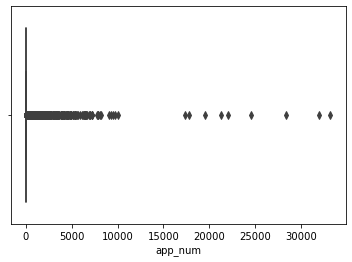

In [53]:
sns.boxplot(lr_train_full.app_num)

<AxesSubplot:xlabel='app_num', ylabel='Count'>

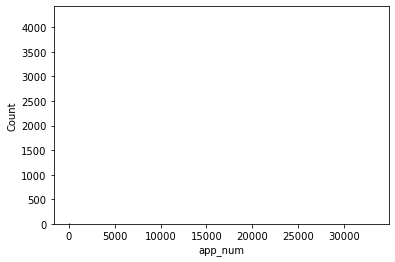

In [52]:
sns.histplot(lr_train_full.app_num)

## Scale and Center (Standardize) LOG Train Data in the context of a pipeline.


In [41]:
#at the beginning of the notebook for consistency sake
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer

# log_train, log_test,log_val
scaler = StandardScaler()
train = log_train.copy()

#scale full train set for cross validation
scaler_full = StandardScaler()
train_full = log_train_full.copy()

#full train for cross validation with lr aggregration
scaler_full_lr = StandardScaler()
train_full_lr = lr_train_full.copy()


#for the linear regression grouped by app yr and geoid
scaler2 = StandardScaler()
train2 = lr_train.copy()

In [43]:
# this is for the train set (not including the validation set)
features = train[numeric]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
train[numeric] = features

#for full train sets for validation
features_full = train_full[numeric]
scaler_full = StandardScaler().fit(features_full.values)
features_full = scaler_full.transform(features_full.values)
train_full[numeric] = features_full

#for full train sets for validation
features_full_lr = train_full_lr[lr_numeric]
scaler_full_lr = StandardScaler().fit(features_full_lr.values)
features_full_lr = scaler_full_lr.transform(features_full_lr.values)
train_full_lr[lr_numeric] = features_full_lr

# For the linear regression by year 
#this is for the train set (not including the validation set)
features2 = train2[lr_numeric]
scaler2 = StandardScaler().fit(features2.values)
features2 = scaler2.transform(features2.values)
train2[lr_numeric] = features2

In [126]:
# for the test data 
test = log_test.copy()
features_test = test[numeric]

# use same scale info from the train data on the test 
#scaler = StandardScaler().fit(features.values)
features_test = scaler.transform(features_test.values)
test[numeric] = features_test


#for the linear regression data
# for the test data 
test2 = lr_test.copy()
features2_test = test2[lr_numeric]

# use same scale info from the train data on the test 
#scaler = StandardScaler().fit(features.values)
features2_test = scaler2.transform(features2_test.values)
test2[lr_numeric] = features2_test

In [127]:
# now for the validation set 
validation = log_val.copy()
features_val = validation[numeric]

# use same scale info from the train data on the validation
#scaler = StandardScaler().fit(features.values)
features_val = scaler.transform(features_val.values)
validation[numeric] = features_val


# for the linear regression
# now for the validation set 
validation2 = lr_val.copy()
features2_val = validation2[lr_numeric]

# use same scale info from the train data on the validation
#scaler = StandardScaler().fit(features.values)
features2_val = scaler2.transform(features2_val.values)
validation2[lr_numeric] = features2_val

In [50]:
train.head(5)

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
1496204,NaN,Motorola Mobility LLC,NaN,2012,13450906,17097,NaN,-0.001001,0.271086,-0.480672,0,motorola mobility llc,NaN,NaN,0,0,0,-0.024647,-0.134218,-0.206114,0.047134,-1.004440,0.317538,0.250038,Great Lakes,0.192150,0.000000,0.424869,0.598905,1.409528,2.236307,0.946200,0.413295,0.434605,0.861474,0.610921,1.293635,3.180445,1.050685,0.683530,0.660166,1.301615,0.732250,0.750459,5078291,20460166,19644,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0,53729471,533705,-0.499732,368186,-0.496833,-0.606501,-0.690861,-0.517793,-0.618290,-0.547191,-0.501710,-0.477033,-0.660077,-0.534646,-0.558445,0.184806,-0.535156,0.466530,-0.435507,-0.554658,-0.507450,-0.518943,-0.561217,-0.551560,-0.569663,-0.581619,-0.613208,-0.507201,-0.582217,-0.458178,0,-0.193347,-0.134176,0.029150,-0.580046,-0.255330,-0.374000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.935243
769278,9435524,"CREE, INC.",2016.0,2012,13453577,37063,F,-0.965448,-0.834902,-0.480672,1,"cree, inc.",NaN,NaN,0,0,0,0.535209,0.774516,-0.414703,-0.471044,-0.759055,-0.056675,0.449710,Southeast,0.000000,0.000000,0.000000,0.549281,0.721550,1.228238,0.693314,0.419640,0.716543,0.602144,0.602939,2.838675,0.712216,0.610061,0.000000,0.925584,0.519697,0.838151,0.848934,2274341,8607168,6713,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,31969194,214358,-0.761397,144984,-0.745586,-0.791065,-0.819798,-0.772265,-0.801977,-0.910759,-0.505115,-0.392928,-0.815163,-0.896422,-0.698254,-0.891177,-0.896803,0.118952,-0.922959,-0.694373,-0.746428,-0.742591,-0.700496,-0.784807,-0.771004,-0.774482,-0.793350,-0.746090,-0.730852,-0.

In [51]:
test.head(5)

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
1289411,NaN,INTERNATIONAL BUSINESS MACHINES CORPORATION,NaN,2013,14134910,36119,NaN,0.963445,0.271086,1.031122,0,international business machines corporation,NaN,NaN,0,0,0,0.535209,-0.315965,-0.045661,-1.219525,-0.881748,-0.036980,0.898970,Mideast,0.407081,0.000000,0.000000,1.297996,0.312941,0.941326,1.054575,0.749395,0.939148,1.140439,1.278497,0.978279,1.701935,0.723991,1.589661,1.325180,1.393669,0.718216,1.264103,6123669,23245496,31680,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,1,1,0,1,71032091,757716,-0.365730,498722,-0.349999,-0.466900,-0.476834,-0.389836,-0.485763,-0.163720,-0.442472,-0.377133,-0.483149,-0.146353,-0.176885,1.106882,-0.146922,1.027445,-0.008576,-0.244399,-0.357806,-0.261092,-0.179122,-0.421636,-0.439196,-0.492302,-0.526519,-0.357699,-0.330739,-0.308583,1,-0.185424,-0.712939,1.081183,0.151393,-0.363288,-0.130623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.935243
396018,10462414,"CABLE TELEVISION LABORATORIES, INC.",2019.0,2013,13832129,08013,H,-0.001001,-0.281908,1.031122,1,"cable television laboratories, inc.",NaN,NaN,0,0,0,-1.032388,-1.497319,-1.618100,-0.499832,-0.943094,1.735608,1.764212,Rocky Mountain,0.324606,0.290228,0.000000,0.640668,1.065329,1.386618,0.944188,0.243468,1.751496,0.475904,0.859442,2.439487,0.478387,0.635086,0.618125,0.877348,1.207795,1.151568,0.954964,1941136,7965096,11696,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,21897977,245687,-0.730777,172422,-0.727281,-0.820256,-0.812743,-0.807851,-0.848978,-0.862387,-0.484580,-0.457151,-0.833321,-0.837213,-0.686986,-0.231083,-0.837588,0.337419,-0.777436,-0.71231

In [52]:
validation.head()

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
1382643,D810362,GENTEX CORPORATION,2018.0,2015,29521510,42069,NaN,-0.001001,-0.281908,1.031122,1,gentex corporation,NaN,NaN,0,0,0,-1.032388,0.183839,2.505542,-0.384681,1.265372,-1.336878,-1.197578,Mideast,0.098722,0.125785,0.941894,0.645993,0.978223,0.965112,1.089195,1.420060,0.907481,1.123399,0.378898,0.464805,0.531173,0.484433,3.056985,1.479250,0.690981,0.820926,0.866902,830944,3412434,5333,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,9152583,175718,-0.806453,104845,-0.777730,-0.911979,-0.897772,-0.867129,-0.943091,-0.957076,-0.558635,-0.479354,-0.922976,-0.927165,-0.742840,-0.876400,-0.927611,0.380810,-0.947751,-0.662513,-0.786765,-0.789001,-0.745594,-0.894618,-0.864396,-0.882042,-0.929853,-0.786412,-0.821567,-0.472249,1,-0.853693,-0.889485,-0.060279,-1.068849,-0.824213,-0.089456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.935243
986431,NaN,NORTHROP GRUMMAN SYSTEMS CORPORATION,NaN,2012,13603788,06037,NaN,-0.483224,-0.281908,-0.480672,0,northrop grumman systems corporation,NaN,NaN,0,0,0,2.774633,1.728687,-0.206114,0.191073,-0.329631,-0.765710,-0.997907,Far West,0.084914,0.103953,0.000000,0.636276,1.002212,1.348362,0.827077,1.166904,2.031002,0.853103,1.321990,1.308068,0.805615,1.037853,1.249140,0.842209,1.244642,0.935039,0.950407,45249168,186494003,249625,0,0,0,0,1,1,0,1,1,0,1,1,0,1,1,0,1,0,0,576713190,7737011,4.719171,5039725,4.765421,3.328665,2.610017,3.683171,3.295966,3.918018,0.868573,0.399928,2.942107,4.050828,4.404904,-0.608780,4.050565,-0.444999,3.759501,4.538342,4.751978,4.607133,4.406552,3.576538,4.188188,4.026071,2.972366

In [128]:
train2.head()

,app_yr,GEOID,app_num,team_size,men_inventors,women_inventors,women_involved,already_granted,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,avg_team_size,avg_men,avg_women,avg_already_granted,avg_women_involved,any_from_r1
5761,2013,55085,-0.150812,-0.142898,-0.144105,-0.146936,-0.142944,-0.139849,-0.129236,-0.130748,-0.056428,-1.083123,-0.502708,0.414618,1.075037,-0.427000,-0.293908,0.135943,Great Lakes,-0.099958,-0.253421,-0.469065,0.063568,-0.418677,-0.246583,2.549281,-0.243900,0.193831,-0.466291,0.096031,-1.154772,-0.361812,-0.587529,-0.647722,0.955005,0.121973,-0.112901,0.068101,-0.254782,-0.271764,-0.296418,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,-0.287551,-0.351480,-0.354012,-0.352527,-0.355477,-0.287873,-0.288955,-0.307668,-0.304350,-0.332655,-0.224666,-0.232628,-0.296841,-0.328685,-0.250213,0.014266,-0.329502,0.014477,-0.295581,-0.327455,-0.358835,-0.306211,-0.255689,-0.307407,-0.329081,-0.333472,-0.286294,-0.358517,-0.303258,-0.184737,-0.125780,-0.702855,1.408390,-0.128618,-0.059537,-0.225131,-0.591319,-0.734069,0.461896,0.203071,0.764556,0
11331,2017,48361,-0.144734,-0.139479,-0.139526,-0.150682,-0.147805,-0.136151,-0.129236,-0.130748,-0.056428,-0.691482,-0.019839,0.774073,1.369501,0.119341,-0.594196,-1.081118,Southwest,-0.321213,-0.018645,-0.469065,1.905544,1.176371,-0.860125,0.310917,-0.130706,-0.666563,-0.199222,-0.003550,-0.335335,-0.559427,0.370383,-0.330547,-1.359805,-0.567670,-0.181401,1.655382,-0.219252,-0.233861,-0.298176,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,-0.230810,-0.258508,-0.268844,-0.267103,-0.254722,-0.256453,-0.253139,-0.275671,-0.273950,-0.246549,-0.362664,-0.374629,-0.263520,-0.247769,-0.241562,0.039003,-0.249226,0.155774,-0.275283,-0.196153,-0.256433,-0.271170,-0.250554,-0.275837,-0.299761,-0.306063,-0.250066,-0.256306,-0.267130,-0.133939,0.017970,0

In [129]:
test2.head()

,app_yr,GEOID,app_num,team_size,men_inventors,women_inventors,women_involved,already_granted,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,avg_team_size,avg_men,avg_women,avg_already_granted,avg_women_involved,any_from_r1
4315,2012,56029,-0.152027,-0.143278,-0.144105,-0.150682,-0.147805,-0.141697,-0.129236,-0.130748,-0.056428,-0.872239,-0.804500,-0.432671,1.128576,0.119341,0.423445,0.391134,Rocky Mountain,-0.321213,-0.253421,-0.469065,1.664328,-0.824465,-0.447485,0.124590,-0.350457,0.252286,-0.224640,-1.299182,-0.189455,-0.533378,-0.814465,-0.647722,-2.683724,0.804623,1.541755,-0.688581,-0.270904,-0.281124,-0.305604,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,-0.290059,-0.371256,-0.365341,-0.363895,-0.371553,-0.291421,-0.307854,-0.323428,-0.300843,-0.335658,-0.220627,-0.311682,-0.305156,-0.333437,-0.239147,0.449659,-0.334234,0.016042,-0.280723,-0.367138,-0.372765,-0.295798,-0.246587,-0.317056,-0.335601,-0.344969,-0.291059,-0.372479,-0.297847,-0.184737,0.062517,-0.955217,1.742460,0.248723,0.017163,-0.225131,-0.270190,-0.018583,-0.605839,-0.312190,-0.650548,0
12510,2018,48049,-0.153243,-0.144417,-0.145478,-0.150682,-0.147805,-0.143546,-0.129236,-0.130748,-0.056428,0.302685,-0.110377,0.401780,0.619956,-0.258895,-0.260543,-0.747407,Southwest,-0.233064,-0.192284,0.277621,-0.369739,0.597454,-0.017118,-0.243986,-0.643847,-0.391669,-0.054777,-0.349690,-0.778431,-0.432371,-0.280596,1.061968,1.076248,-0.193885,0.007797,0.423649,-0.253523,-0.271385,-0.333801,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,-0.289537,-0.351661,-0.359685,-0.358219,-0.351354,-0.290430,-0.294144,-0.310855,-0.311579,-0.334692,-0.437355,-0.523572,-0.303008,-0.329364,-0.254861,-0.266466,-0.331106,0.015902,-0.313602,-0.303596,-0.354308,-0.296946,-0.267518,-0.311893,-0.329215,-0.336393,-0.286554,-0.353838,-0.308668,-0.184737,-0.070

In [130]:
validation2.head()

,app_yr,GEOID,app_num,team_size,men_inventors,women_inventors,women_involved,already_granted,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,avg_team_size,avg_men,avg_women,avg_already_granted,avg_women_involved,any_from_r1
2184,2011,31153,-0.139872,-0.131880,-0.134031,-0.135699,-0.133224,-0.130605,-0.129236,-0.130748,-0.056428,-0.992744,-1.347727,-1.575227,1.530118,0.665682,1.541182,0.705214,Plains,-0.321213,-0.253421,-0.469065,1.650936,-0.769613,1.626028,0.674217,0.176364,0.153916,0.529090,0.151364,0.898099,0.454773,-0.193055,0.930622,-0.916893,0.055051,0.152615,0.056643,-0.190102,-0.195130,-0.155833,0,0,0,1,0,1,1,1,0,0,0,1,0,0,1,0,0,1,1,-0.169666,-0.125073,-0.064467,-0.078485,-0.103792,-0.157863,-0.200589,-0.133009,-0.131647,-0.104086,-0.071972,0.020042,-0.168312,-0.132929,-0.208878,-0.076434,-0.133177,0.230062,-0.156560,-0.212378,-0.096003,-0.171107,-0.208158,-0.132919,-0.129900,-0.116728,-0.150793,-0.095797,-0.177248,-0.166227,-0.513133,-0.216471,-0.763659,-0.345387,-0.254063,-0.163539,0.532633,0.160288,0.461896,-0.054559,0.410780,0
5534,2013,48053,-0.142303,-0.139479,-0.139984,-0.150682,-0.147805,-0.138000,-0.129236,-0.130748,-0.056428,1.206472,-0.200915,-0.522535,1.075037,-0.973341,0.156523,-0.335177,Southwest,-0.321213,0.453892,-0.469065,1.449868,-0.459274,-0.559461,1.216179,-0.820840,0.157628,0.023770,2.157026,-0.418107,-0.586214,0.731521,-0.109463,-0.610567,0.776761,0.659319,0.394754,-0.262817,-0.280161,-0.314870,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,-0.295340,-0.339983,-0.347167,-0.345702,-0.340037,-0.294534,-0.300782,-0.328615,-0.320652,-0.330550,-0.362374,-0.392105,-0.310813,-0.318040,-0.229311,-0.118972,-0.319461,0.040193,-0.255390,-0.326753,-0.342246,-0.245504,-0.238748,-0.326924,-0.327878,-0.349934,-0.294920,-0.341923,-0.292088,-0.184737,-0.552053,-0.809042,0.41763

In [44]:
train_full.head()

,patent_num,assignee,grant_yr,app_yr,app_num,GEOID,ipc,team_size,men_inventors,women_inventors,already_granted,assignee_univ_map,Institution,Control,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,women_involved,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,ipc_A,ipc_B,ipc_C,ipc_D,ipc_E,ipc_F,ipc_G,ipc_H,num_ipcs
239386,9839560,"CORIUM INTERNATIONAL, INC.",2017.0,2011,13014523,06081,A,-0.001203,0.270810,-0.480462,1,"corium international, inc.",NaN,NaN,0,0,0,0.274306,-0.588403,-0.703360,0.219829,0.038517,0.514073,0.249846,Far West,0.000000,0.043031,0.000000,0.956901,0.000000,1.400695,0.834953,2.265862,2.973706,0.875405,1.189712,1.431205,0.901941,0.821604,0.643790,0.644133,0.924921,1.002340,0.857803,5304241,21539117,19724,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0,62275518,570786,-0.485601,391469,-0.490762,-0.527931,-0.589975,-0.542351,-0.589537,-0.426199,-0.139721,-0.231695,-0.592422,-0.416534,-0.307729,0.776367,-0.416577,0.528311,-0.266818,-0.528597,-0.492046,-0.437423,-0.309068,-0.559438,-0.561976,-0.597306,-0.556007,-0.492127,-0.550858,-0.347661,0,0.015953,-0.039243,-0.102098,-0.452293,-0.080026,-0.114564,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296869
452837,10180974,INTERNATIONAL BUSINESS MACHINES CORPORATION,2019.0,2014,14487801,36119,G H,0.962766,0.270810,2.540645,1,international business machines corporation,NaN,NaN,0,0,0,0.498337,-0.224830,-0.125733,-1.161332,-1.004710,0.021781,0.932007,Mideast,0.413989,0.005067,0.000000,1.302638,0.301853,0.962435,1.061979,0.675346,0.875025,1.146248,1.305534,0.956514,1.832258,0.688604,1.618768,1.311185,1.504001,0.737318,1.286837,6453595,24211828,31692,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,1,1,0,1,73311986,764266,-0.362226,501796,-0.346455,-0.458792,-0.459980,-0.392946,-0.458359,-0.137790,-0.486360,-0.461451,-0.461290,-0.104750,-0.223346,1.282025,-0.105395,1.072971,0.095978,-0.225758,-0.356327,-0.249603,-

In [45]:
train_full_lr.head()

,app_yr,GEOID,app_num,team_size,men_inventors,women_inventors,women_involved,already_granted,r1,r2,special_focus,Over25_Less9Grade,Over25_SomeHS,Over25_HSGrad,Over25_SomeCollege,Over25_Assosc,Over25_Bach,Over25_Grad,bea_region,Agriculture_Forestry_Fishing_Hunting,Mining_Quarrying_and_Oil_Gas_Extraction,Utilities,Construction,Manufacturing,Wholesale_Trade,Retail_Trade,Transportation_Warehousing,Information,Finance_Insurance,Real_Estate_Rental_Leasing,Professional_Scientific_and_Technical_Services,Management_of_Companies_Enterprises,Administrative_Support_Waste_Management_Remediation_Services,Educational_Services,Health_Care_Social_Assistance,Arts_Entertainment_and_Recreation,Accommodation_Food_Services,Other_Services_except_Public_Administration,qp1,ap,est,Agriculture_Forestry_Fishing_Hunting_base,Mining_Quarrying_and_Oil_Gas_Extraction_base,Utilities_base,Construction_base,Manufacturing_base,Wholesale_Trade_base,Retail_Trade_base,Transportation_Warehousing_base,Information_base,Finance_Insurance_base,Real_Estate_Rental_Leasing_base,Professional_Scientific_and_Technical_Services_base,Management_of_Companies_Enterprises_base,Administrative_Support_Waste_Management_Remediation_Services_base,Educational_Services_base,Health_Care_Social_Assistance_base,Arts_Entertainment_and_Recreation_base,Accommodation_Food_Services_base,Other_Services_except_Public_Administration_base,GDP,pop_gt_16,pop_gt_16_lf,pop_gt_16_lf_c,Pop_Est,Earnings_by_place_of_work,Employee_and_self-employed_contributions_for_government_social_insurance,Employer_contributions_for_employee_pension_and_insurance_funds,Employer_contributions_for_government_social_insurance,Equals_Net_earnings_by_place_of_residence,Farm_income,Farm_proprietors_income,Less_Contributions_for_government_social_insurance,Nonfarm_personal_income,Nonfarm_proprietors_income,Per_capita_personal_income_dollars,Personal_income_thousands_of_dollars,Plus_Adjustment_for_residence,Plus_Dividends_interest_and_rent,Plus_Personal_current_transfer_receipts,Population_persons,Proprietors_employment,Proprietors_income,Supplements_to_wages_and_salaries,Total_employment,Wage_and_salary_employment,Wages_and_salaries,Population_Estimate,Applications,Award_Amount,GDP_by_labor_force,ap_by_est,est_by_pop_gt_16_lf,apps_by_pop_gt_16_lf,Wages_by_pop_gt_16_lf,Award_by_pop_gt_16_lf,avg_team_size,avg_men,avg_women,avg_already_granted,avg_women_involved,any_from_r1
4963,2013,27053,3.887149,3.731560,3.858213,4.091582,4.091343,3.242747,2.539212,-0.131095,-0.055758,-0.513530,-1.141319,-1.877137,-0.398606,-0.136352,2.453505,1.445927,Plains,-0.305797,-0.252915,-0.468480,-0.840677,-0.552516,0.462616,-1.673660,-0.148993,0.920857,2.445938,0.883727,1.369145,5.653827,1.127333,0.295010,-0.325185,0.103761,-0.694483,-0.657165,3.373580,3.532892,2.748197,0,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,2.784196,2.062638,2.319153,2.328315,2.038748,2.957233,3.282812,2.664669,3.579182,2.392569,-0.123191,-0.113314,3.430442,2.351490,1.766010,1.395829,2.349773,-2.926878,2.442152,1.782096,2.062872,2.039130,1.761070,2.962257,3.096305,3.388096,3.154066,2.061631,1.836668,2.157418,1.515964,2.746331,0.547402,0.313630,2.622371,0.795603,0.751567,0.652174,0.467169,-0.174606,0.449844,1
9519,2016,36015,-0.139072,-0.134578,-0.135536,-0.138616,-0.133161,-0.128699,-0.128891,-0.131095,-0.055758,-0.755411,-0.324214,0.295883,-0.775189,1.799625,-0.391843,0.398238,Mideast,-0.320405,-0.137759,-0.468480,-0.505856,0.346794,0.117797,0.496930,-0.084635,-0.057456,-0.213970,0.101412,-0.420170,-0.188121,0.167620,0.790941,0.780435,-0.076267,-0.400608,-0.609145,-0.198989,-0.211802,-0.257432,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,-0.225940,-0.241547,-0.261190,-0.259447,-0.243861,-0.225211,-0.227028,-0.200482,-0.223166,-0.259358,-0.292772,-0.289998,-0.225677,-0.254126,-0.234625,-0.200849,-0.255296,0.014456,-0.271029,-0.188143,-0.252433,-0.284489,-0.241661,-0.208204,-0.259822,-0.250535,-0.222367,-0.252235,-0.282894,-0.092347,0.019576,0.544769,-0.223795,-0.558824,0.248144,0.435838,-0.51

## Save Data

In [46]:
train_full.to_csv('Log_train_full_standardized_for_CV.csv', index = False)
train_full_lr.to_csv('Lr_train_full_standardized_for_CV.csv', index = False)


In [53]:
# this is the log regression 
train.to_csv('Log_train_standardized.csv', index = False)
test.to_csv('Log_test_standardized.csv', index = False)
validation.to_csv('Log_validation_standardized.csv', index = False)
#patents_test_val.to_csv('patents_full_test.csv')